<a href="https://colab.research.google.com/github/vadhri/distibuted-optimization/blob/main/Stabiilty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

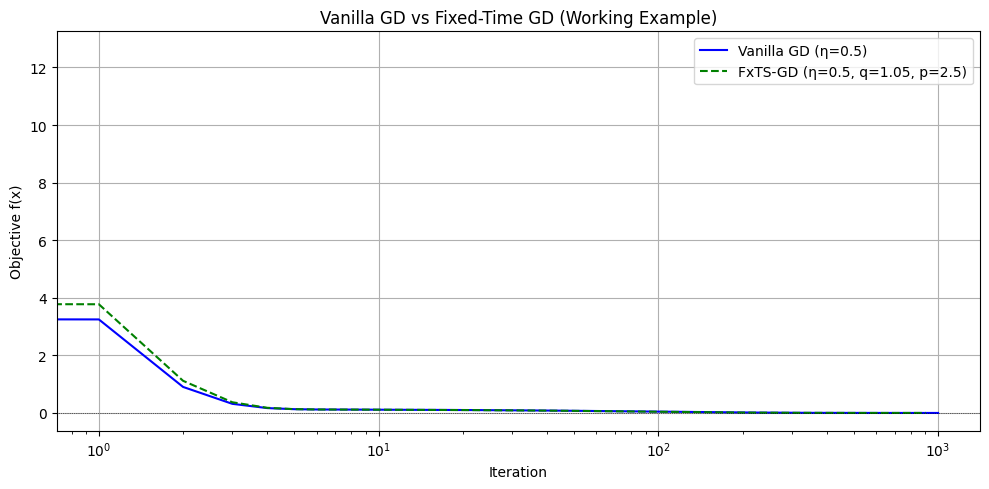

Vanilla GD converged in 1001 steps.
FxTS-GD converged in 905 steps.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Objective: Quadratic bowl
def f(x):
    return 0.5 * (x[0]**2 + 0.01 * x[1]**2)

def grad_f(x):
    return np.array([x[0], 0.01 * x[1]])

# Parameters
eta_gd = 0.5         # Step size for vanilla GD
eta_fx = 0.5         # Step size for fixed-time GD
p = 2.5
q = 1.05             # Very fast convergence
eps = 1e-6
max_iters = 1000     # Cap

# Initial condition
x0 = np.array([5.0, 5.0])

# Vanilla GD
x_gd = x0.copy()
f_vals_gd = [f(x_gd)]
for _ in range(max_iters):
    if f_vals_gd[-1] <= eps:
        break
    x_gd = x_gd - eta_gd * grad_f(x_gd)
    f_vals_gd.append(f(x_gd))

# FxTS GD
x_fx = x0.copy()
f_vals_fx = [f(x_fx)]
for _ in range(max_iters):
    f_val = f(x_fx)
    if f_val <= eps:
        break
    scale = f_val ** (-(q - 1) / (p - 1))
    x_fx = x_fx - eta_fx * grad_f(x_fx) * scale
    f_vals_fx.append(f(x_fx))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(f_vals_gd, label=f"Vanilla GD (η={eta_gd})", color="blue")
plt.plot(f_vals_fx, label=f"FxTS-GD (η={eta_fx}, q={q}, p={p})", color="green", linestyle="--")
plt.axhline(0, color='black', linewidth=0.5, linestyle=':')
plt.xlabel("Iteration")
plt.ylabel("Objective f(x)")
plt.title("Vanilla GD vs Fixed-Time GD (Working Example)")
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print result
print(f"Vanilla GD converged in {len(f_vals_gd)} steps.")
print(f"FxTS-GD converged in {len(f_vals_fx)} steps.")


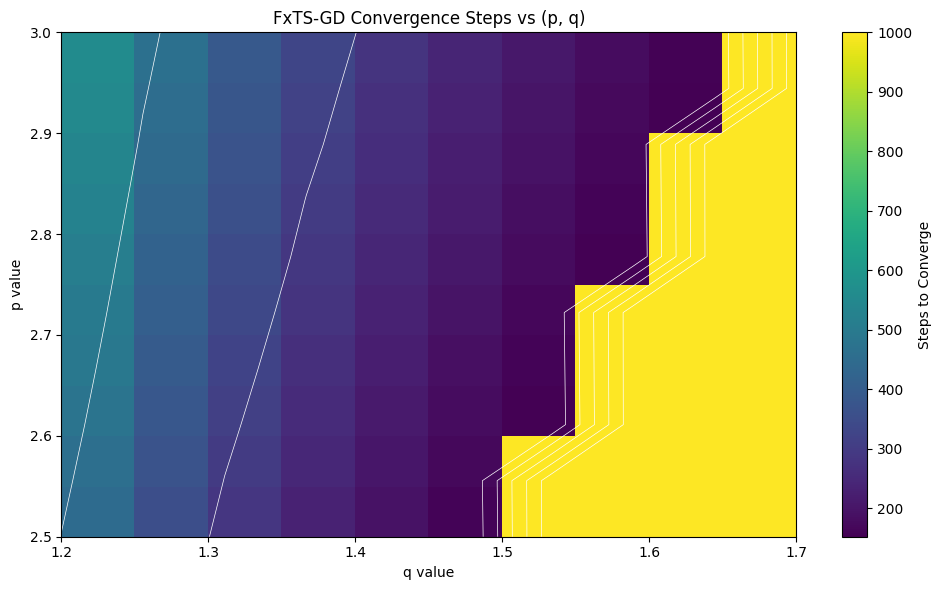

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Objective: Quadratic bowl ---
def f(x):
    return 0.5 * (x[0]**2 + 0.01 * x[1]**2)

def grad_f(x):
    return np.array([x[0], 0.01 * x[1]])

# --- Fixed parameters ---
eta_fx = 0.5
eps = 1e-6
max_iters = 1000
x0 = np.array([5.0, 5.0])

# --- Grid of (p, q) values ---
p_values = np.linspace(2.5, 3.0, 10)     # p > 1
q_values = np.linspace(1.2, 1.7, 10)   # q > 1
convergence_steps = np.zeros((len(p_values), len(q_values)))

# --- Grid search ---
for i, p in enumerate(p_values):
    for j, q in enumerate(q_values):
        x = x0.copy()
        steps = 0
        for _ in range(max_iters):
            f_val = f(x)
            if f_val <= eps:
                break
            scale = f_val ** (-(q - 1) / (p - 1))
            x = x - eta_fx * grad_f(x) * scale
            steps += 1
        convergence_steps[i, j] = steps

# --- Plotting heatmap ---
plt.figure(figsize=(10, 6))
plt.imshow(convergence_steps, origin='lower', cmap='viridis',
           extent=[q_values[0], q_values[-1], p_values[0], p_values[-1]],
           aspect='auto')
plt.colorbar(label="Steps to Converge")
plt.xlabel("q value")
plt.ylabel("p value")
plt.title("FxTS-GD Convergence Steps vs (p, q)")
plt.contour(q_values, p_values, convergence_steps, colors='white', linewidths=0.5)
plt.tight_layout()
plt.show()


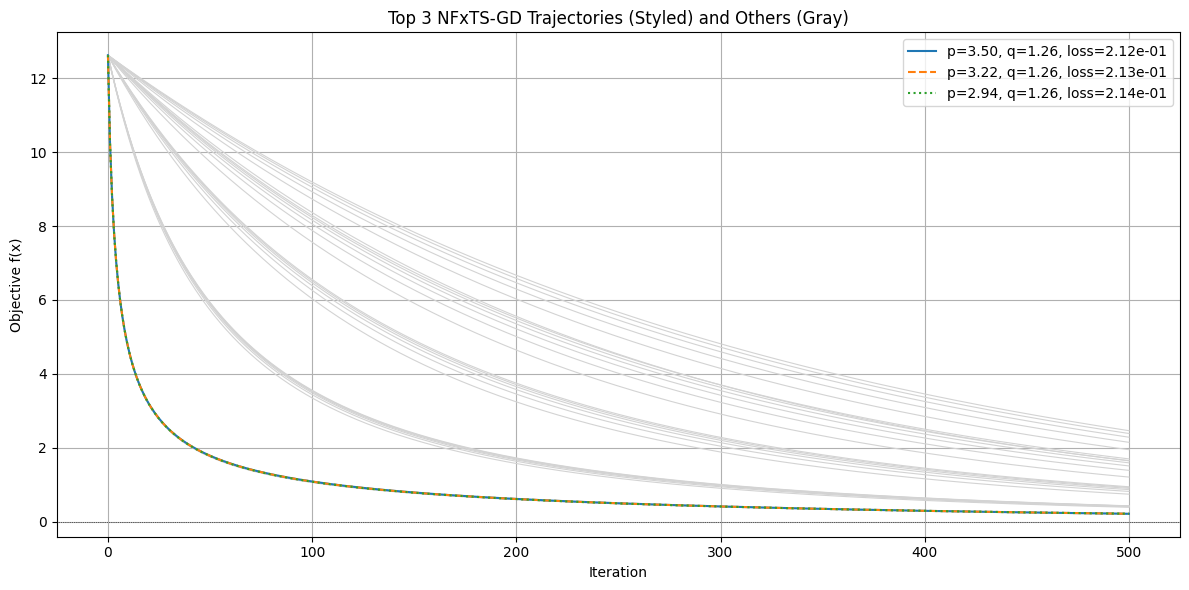

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Objective and derivatives
def f(x):
    return 0.5 * (x[0]**2 + 0.01 * x[1]**2)

def grad_f(x):
    return np.array([x[0], 0.02 * x[1]])

def hessian_f(x):
    return np.array([[1.0, 0.0], [0.0, 0.02]])

# Parameters
eta_nfx = 0.001
eps = 1e-6
max_iters = 500
x0 = np.array([5.0, 5.0])
safe_min = 1e-4
grad_max = 1e4  # explosion threshold

# Grid of (p, q) values
p_values = np.linspace(2.1, 3.5, 6)
q_values = np.linspace(1.1, 1.9, 6)

# Store all runs
results = []

for p in p_values:
    for q in q_values:
        x_nfx = x0.copy()
        f_vals_nfx = [f(x_nfx)]
        success = True
        for _ in range(max_iters):
            grad = grad_f(x_nfx)
            grad_norm = np.linalg.norm(grad)
            if f(x_nfx) <= eps or grad_norm < eps or grad_norm > grad_max:
                break
            hess_inv = np.linalg.inv(hessian_f(x_nfx))
            grad_norm = max(grad_norm, safe_min)
            term1 = grad / (grad_norm ** ((p - 2) / (p - 1)))
            term2 = grad / (grad_norm ** ((q - 2) / (q - 1)))
            update = hess_inv @ (term1 + term2)
            x_new = x_nfx - eta_nfx * update
            if f(x_new) > f_vals_nfx[-1]:
                success = False
                break
            x_nfx = x_new
            f_vals_nfx.append(f(x_nfx))
        results.append({
            'p': p,
            'q': q,
            'loss': f_vals_nfx[-1],
            'trajectory': f_vals_nfx,
            'success': success
        })

# Sort by final loss and pick top 3
top_results = sorted(results, key=lambda r: r['loss'])[:3]
line_styles = ['solid', 'dashed', 'dotted']

# Plotting all other runs in light gray
plt.figure(figsize=(12, 6))
for res in results:
    if res not in top_results:
        plt.plot(range(len(res['trajectory'])), res['trajectory'], color='lightgray', linewidth=0.8)

# Top 3 in color with different styles
for idx, res in enumerate(top_results):
    style = line_styles[idx % len(line_styles)]
    label = f"p={res['p']:.2f}, q={res['q']:.2f}, loss={res['loss']:.2e}"
    if not res['success']:
        label += " (stopped)"
    plt.plot(range(len(res['trajectory'])), res['trajectory'], label=label, linestyle=style)

plt.axhline(0, color='black', linewidth=0.5, linestyle=':')
plt.xlabel("Iteration")
plt.ylabel("Objective f(x)")
plt.title("Top 3 NFxTS-GD Trajectories (Styled) and Others (Gray)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Best p=3.220, q=1.260, final loss=8.79e-07


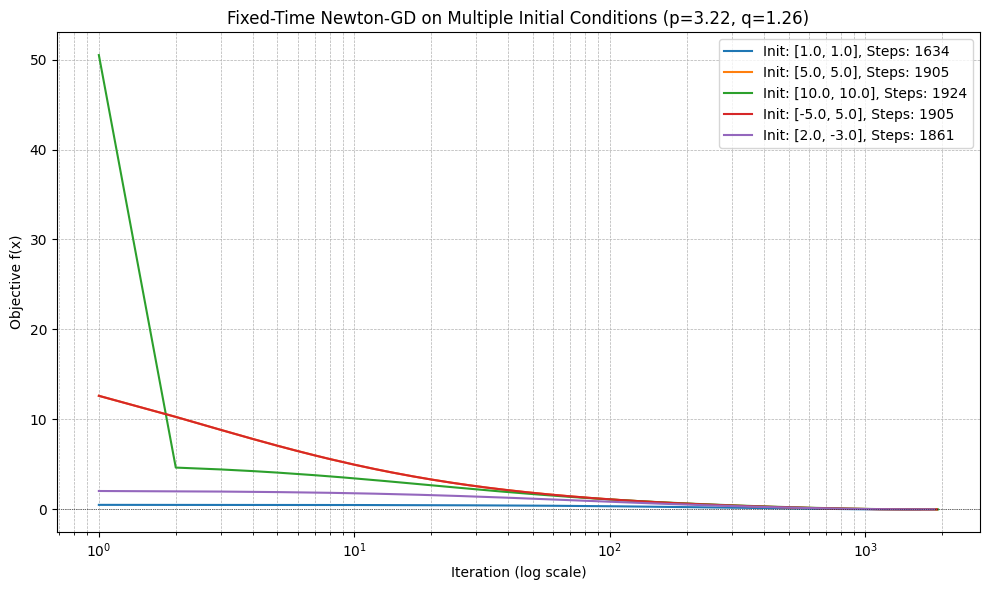

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Objective and derivatives
def f(x):
    return 0.5 * (x[0]**2 + 0.01 * x[1]**2)

def grad_f(x):
    return np.array([x[0], 0.01 * x[1]])

def hessian_f(x):
    return np.array([[1.0, 0.0], [0.0, 0.02]])

# Parameters
eta_nfx = 0.001
eps = 1e-6
max_iters = 2000
safe_min = 1e-4
grad_max = 1e4

# Grid to find best (p, q)
p_values = np.linspace(2.1, 3.5, 6)
q_values = np.linspace(1.1, 1.9, 6)

results = []

# Step 1: Find best (p, q)
for p in p_values:
    for q in q_values:
        x = np.array([5.0, 5.0])
        f_vals = [f(x)]
        success = True
        for _ in range(max_iters):
            grad = grad_f(x)
            grad_norm = np.linalg.norm(grad)
            if f(x) <= eps or grad_norm < eps or grad_norm > grad_max:
                break
            grad_norm = max(grad_norm, safe_min)
            hess_inv = np.linalg.inv(hessian_f(x))
            term1 = grad / (grad_norm ** ((p - 2) / (p - 1)))
            term2 = grad / (grad_norm ** ((q - 2) / (q - 1)))
            update = hess_inv @ (term1 + term2)
            x_new = x - eta_nfx * update
            if f(x_new) > f_vals[-1]:
                success = False
                break
            x = x_new
            f_vals.append(f(x))
        results.append({'p': p, 'q': q, 'loss': f_vals[-1], 'trajectory': f_vals, 'success': success})

# Get best result
best = sorted(results, key=lambda r: r['loss'])[0]
p_best, q_best = best['p'], best['q']
print(f"Best p={p_best:.3f}, q={q_best:.3f}, final loss={best['loss']:.2e}")

# Step 2: Test multiple initial conditions
initial_conditions = [
    np.array([1.0, 1.0]),
    np.array([5.0, 5.0]),
    np.array([10.0, 10.0]),
    np.array([-5.0, 5.0]),
    np.array([2.0, -3.0])
]

trajectories = []
for x0 in initial_conditions:
    x = x0.copy()
    f_vals = [f(x)]
    for _ in range(max_iters):
        grad = grad_f(x)
        grad_norm = np.linalg.norm(grad)
        if f(x) <= eps or grad_norm < eps or grad_norm > grad_max:
            break
        grad_norm = max(grad_norm, safe_min)
        hess_inv = np.linalg.inv(hessian_f(x))
        term1 = grad / (grad_norm ** ((p_best - 2) / (p_best - 1)))
        term2 = grad / (grad_norm ** ((q_best - 2) / (q_best - 1)))
        update = hess_inv @ (term1 + term2)
        x = x - eta_nfx * update
        f_vals.append(f(x))
    trajectories.append((x0, f_vals))

# Step 3: Plot (log x-axis)
plt.figure(figsize=(10, 6))
for x0, traj in trajectories:
    label = f"Init: [{x0[0]:.1f}, {x0[1]:.1f}], Steps: {len(traj)}"
    plt.plot(range(1, len(traj)+1), traj, label=label)  # start from 1 to avoid log(0)

plt.axhline(0, color='black', linestyle=':', linewidth=0.5)
plt.xscale("log")
plt.xlabel("Iteration (log scale)")
plt.ylabel("Objective f(x)")
plt.title(f"Fixed-Time Newton-GD on Multiple Initial Conditions (p={p_best:.2f}, q={q_best:.2f})")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


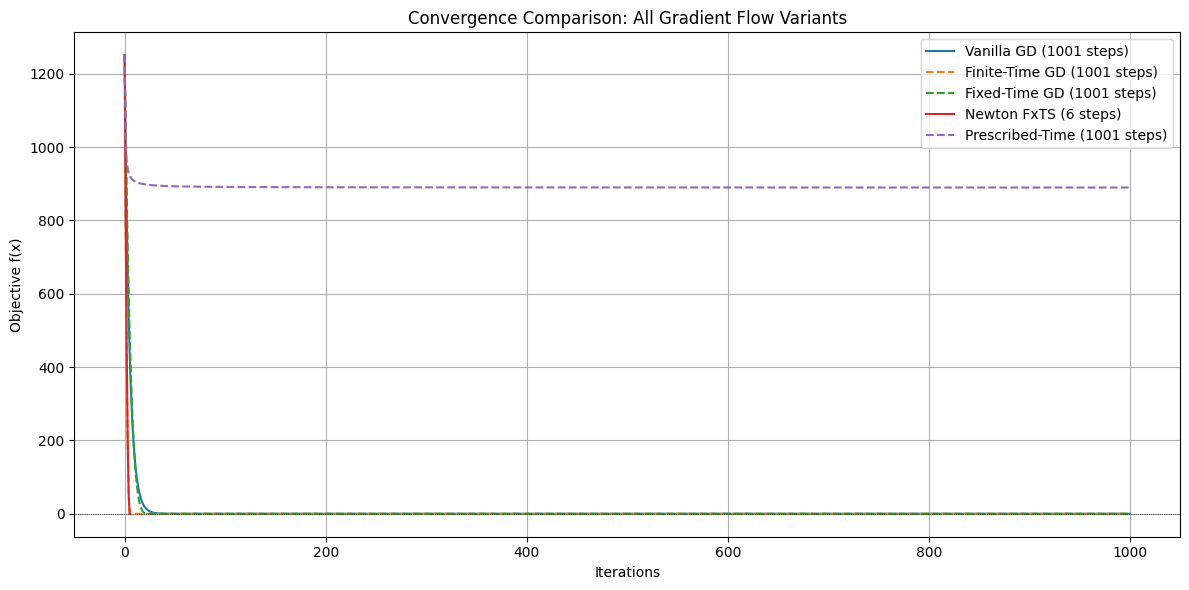

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Objective function (moderately stiff)
def f(x):
    return 0.5 * (100 * x[0]**2 + 0.01 * x[1]**2)

def grad_f(x):
    return np.array([100 * x[0], 0.02 * x[1]])

def hessian_f(x):
    return np.array([[100.0, 0.0], [0.0, 0.02]])

# Parameters
eta = 0.001
theta = 3 * eta
p, q = 2.5, 1.4
eps = 1e-6
max_iters = 1000
safe_min = 1e-10
grad_max = 1e5
x0 = np.array([5.0, 5.0])
max_step = 1.0

methods = {}

# --- Vanilla GD ---
x = x0.copy()
vals = [f(x)]
for _ in range(max_iters):
    if f(x) <= eps:
        break
    x -= eta * grad_f(x)
    vals.append(f(x))
methods["Vanilla GD"] = vals

# --- Finite-Time GD ---
x = x0.copy()
vals = [f(x)]
for _ in range(max_iters):
    fx = f(x)
    if fx <= eps:
        break
    grad = grad_f(x)
    norm = np.clip(np.linalg.norm(grad), safe_min, grad_max)
    scale = 1.0 / (norm ** ((q - 2) / (q - 1)))
    step = theta * grad * scale
    step = np.clip(step, -max_step, max_step)
    x -= step
    vals.append(f(x))
methods["Finite-Time GD"] = vals

# --- Fixed-Time GD ---
x = x0.copy()
vals = [f(x)]
for _ in range(max_iters):
    fx = f(x)
    if fx <= eps:
        break
    grad = grad_f(x)
    norm = np.clip(np.linalg.norm(grad), safe_min, grad_max)
    fx = np.clip(fx, safe_min, grad_max)
    s1 = norm ** (-(p - 2) / (p - 1))
    s2 = fx ** (-(q - 1) / (p - 1))
    scale = s1 + s2
    step = theta * grad * scale
    step = np.clip(step, -max_step, max_step)
    x -= step
    vals.append(f(x))
methods["Fixed-Time GD"] = vals

# --- Newton-based FxTS ---
x = x0.copy()
vals = [f(x)]
for _ in range(max_iters):
    fx = f(x)
    grad = grad_f(x)
    norm = np.clip(np.linalg.norm(grad), safe_min, grad_max)
    if fx <= eps:
        break
    hess_inv = np.linalg.inv(hessian_f(x))
    term1 = grad / (norm ** ((p - 2) / (p - 1)))
    term2 = grad / (norm ** ((q - 2) / (q - 1)))
    update = hess_inv @ (term1 + term2)
    step = theta * update
    step = np.clip(step, -max_step, max_step)
    x -= step
    vals.append(f(x))
methods["Newton FxTS"] = vals

# --- Prescribed-Time-Inspired ---
x = x0.copy()
vals = [f(x)]
for t in range(1, max_iters + 1):
    if f(x) <= eps:
        break
    decay = 1 / (t**2)
    step = eta * grad_f(x) * decay
    step = np.clip(step, -max_step, max_step)
    x -= step
    vals.append(f(x))
methods["Prescribed-Time"] = vals

# --- Plotting ---
plt.figure(figsize=(12, 6))
for name, vals in methods.items():
    plt.plot(vals, label=f"{name} ({len(vals)} steps)", linestyle="--" if "Time" in name else "-")
plt.axhline(0, color='black', linestyle=':', linewidth=0.5)
plt.xlabel("Iterations")
plt.ylabel("Objective f(x)")
plt.title("Convergence Comparison: All Gradient Flow Variants")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Finite time stability


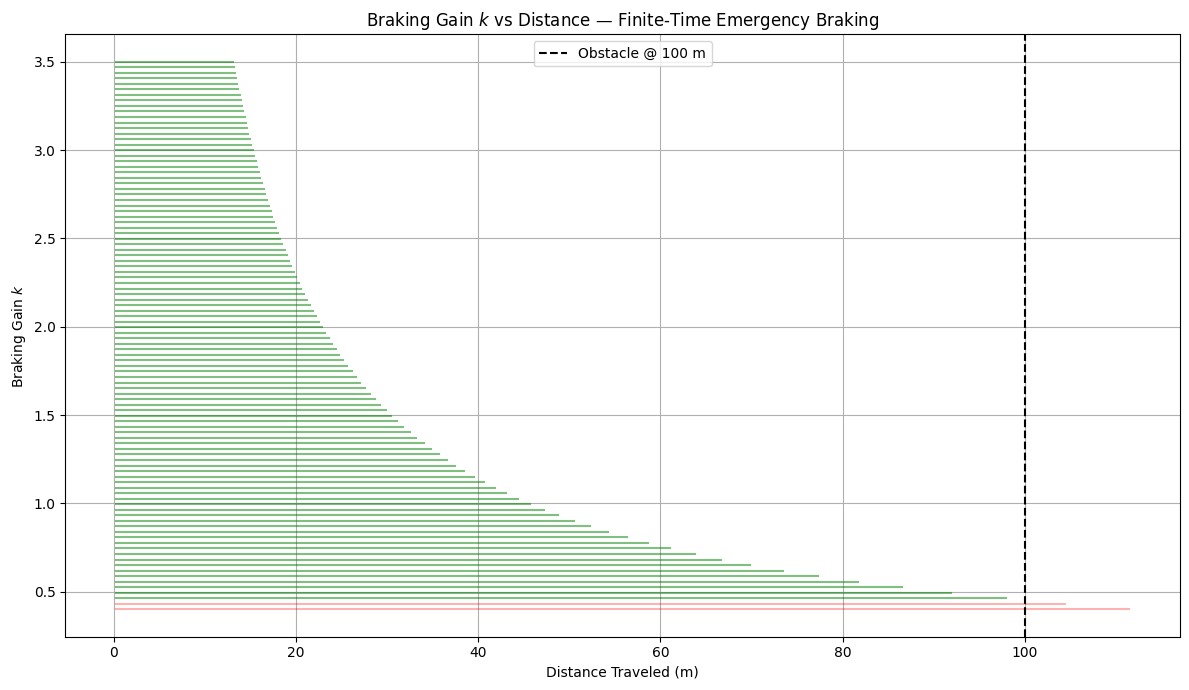

✔️ Minimum safe braking gain to stop before obstacle: k ≈ 0.463


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
v0 = 16.67  # Initial speed in m/s (60 km/h)
alpha = 0.5  # Nonlinearity in braking
D_obstacle = 100  # Obstacle at 100 meters

# k range
k_values = np.linspace(0.4, 3.5, 100)  # braking gains
t = np.linspace(0, 15, 1000)  # simulate 15 seconds
dt = t[1] - t[0]

# Set up plot
plt.figure(figsize=(12, 7))

# Track critical values
k_safe = []

for k in k_values:
    # Compute v(t)
    v_alpha = np.maximum(v0**(1 - alpha) - k * (1 - alpha) * t, 0)
    v_t = v_alpha**(1 / (1 - alpha))

    # Integrate to get distance
    x_t = np.cumsum(v_t) * dt
    x_final = x_t[-1]

    if x_final <= D_obstacle:
        plt.plot(x_t, [k]*len(x_t), color='green', alpha=0.5)
        k_safe.append(k)
    else:
        plt.plot(x_t, [k]*len(x_t), color='red', alpha=0.3)

# Obstacle line
plt.axvline(x=D_obstacle, color='black', linestyle='--', label='Obstacle @ 100 m')

# Labels and styling
plt.xlabel('Distance Traveled (m)')
plt.ylabel('Braking Gain $k$')
plt.title('Braking Gain $k$ vs Distance — Finite-Time Emergency Braking')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Report safe range
print(f"Minimum safe braking gain to stop before obstacle: k ≈ {min(k_safe):.3f}")


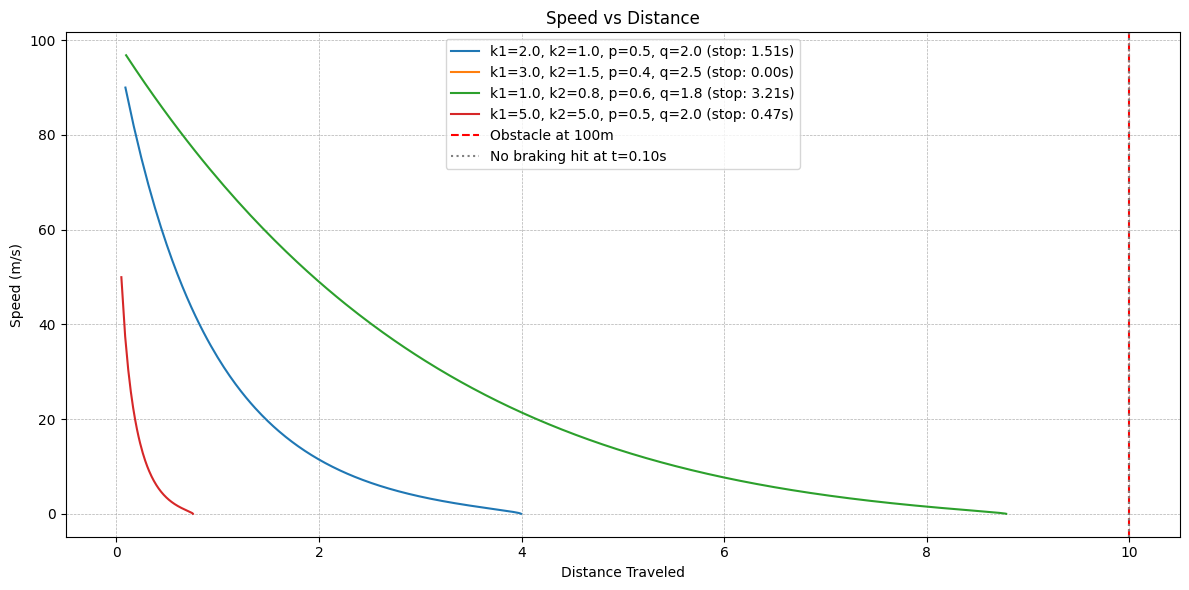

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Time settings
v0 = 100  # Initial speed in m/s (100 km/h)
t_max = 5.0  # Maximum simulation time in seconds
dt = 0.001  # Time step
t = np.arange(0, t_max, dt)
D_obstacle = 10  # meters
T_collision = D_obstacle / v0  # Time to collision without braking

# Parameter sets for (k1, k2, p, q)
param_sets = [
    {"k1": 2.0, "k2": 1.0, "p": 0.5, "q": 2.0},
    {"k1": 3.0, "k2": 1.5, "p": 0.4, "q": 2.5},
    {"k1": 1.0, "k2": 0.8, "p": 0.6, "q": 1.8},
    {"k1": 5.0, "k2": 5.0, "p": 0.5, "q": 2.0}
]

# Plot setup
plt.figure(figsize=(12, 6))

# Simulate each parameter set
for params in param_sets:
    v = v0
    x = 0
    v_hist, x_hist = [], []
    stop_time = 0.0

    for ti in t:
        if v <= 0:
            stop_time = ti
            break
        a = -params["k1"] * v**params["p"] - params["k2"] * v**params["q"]
        v += a * dt
        v = max(v, 0)
        x += v * dt
        v_hist.append(v)
        x_hist.append(x)

    label = f"k1={params['k1']}, k2={params['k2']}, p={params['p']}, q={params['q']} (stop: {stop_time:.2f}s)"
    plt.plot(x_hist, v_hist, label=label)

# Obstacle markers
plt.axvline(D_obstacle, color='red', linestyle='--', label='Obstacle at 100m')
plt.axvline(v0 * T_collision, color='gray', linestyle=':', label=f'No braking hit at t={T_collision:.2f}s')

# Log scale on X-axis
# plt.xscale('log')
plt.xlabel("Distance Traveled")
plt.ylabel("Speed (m/s)")
plt.title("Speed vs Distance")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


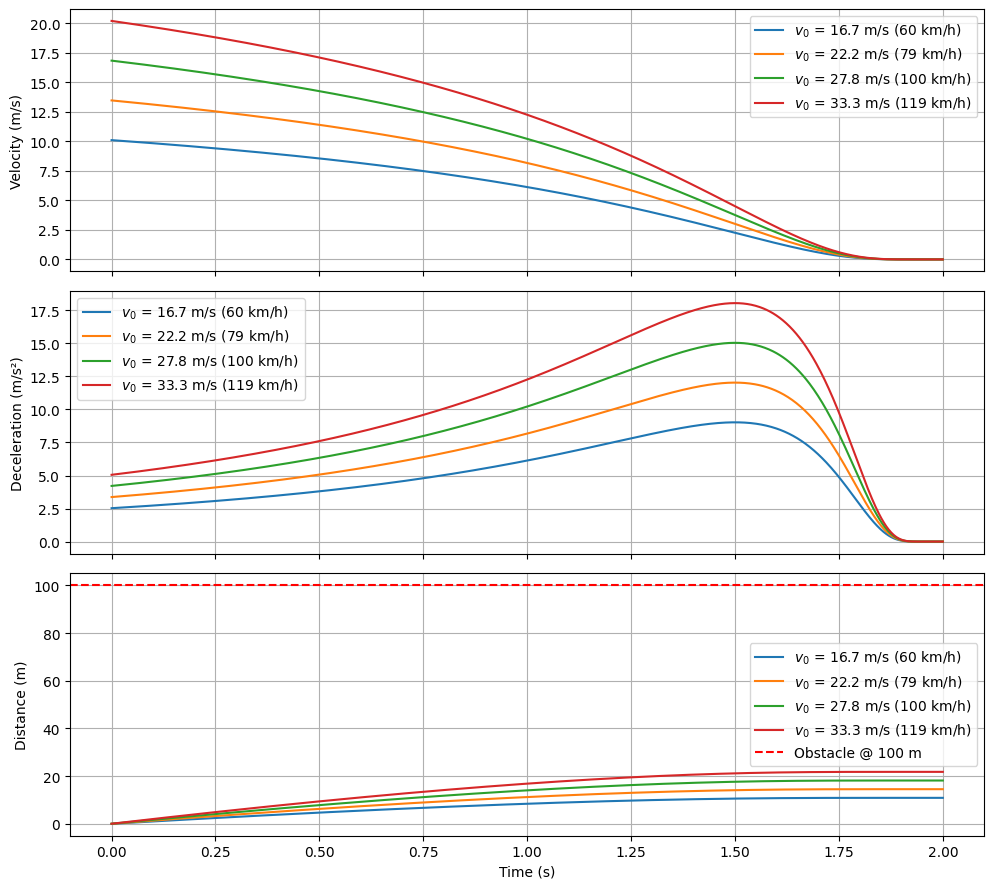

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
initial_speeds = [16.67, 22.22, 27.78, 33.33]
T = 2.0
r = 1.0
gamma = 2.0      # Must be >1

# Time vector (avoid hitting T exactly)
t = np.linspace(0, T - 1e-4, 1000)
dt = t[1] - t[0]
tau = np.clip(T - t, 1e-6, T)

# Setup plots
fig, axs = plt.subplots(3, 1, figsize=(10, 9), sharex=True)

for v0 in initial_speeds:
    # Prescribed-time velocity
    v_t = v0 * np.exp(-r * tau**(1 - gamma))

    # Acceleration
    a_t = r * (1 - gamma) * tau**(-gamma) * v_t

    # Distance
    x_t = np.cumsum(v_t) * dt

    # Append final value for smooth plot
    t_ext = np.append(t, T)
    v_ext = np.append(v_t, 0)
    a_ext = np.append(a_t, 0)
    x_ext = np.append(x_t, x_t[-1])

    label = f"$v_0$ = {v0:.1f} m/s ({int(v0 * 3.6)} km/h)"

    axs[0].plot(t_ext, v_ext, label=label)
    axs[1].plot(t_ext, -a_ext, label=label)
    axs[2].plot(t_ext, x_ext, label=label)

# Plot settings
axs[0].set_ylabel("Velocity (m/s)")
axs[0].legend()
axs[0].grid(True)

axs[1].set_ylabel("Deceleration (m/s²)")
axs[1].legend()
axs[1].grid(True)

axs[2].set_ylabel("Distance (m)")
axs[2].set_xlabel("Time (s)")
axs[2].axhline(100, linestyle='--', color='red', label='Obstacle @ 100 m')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


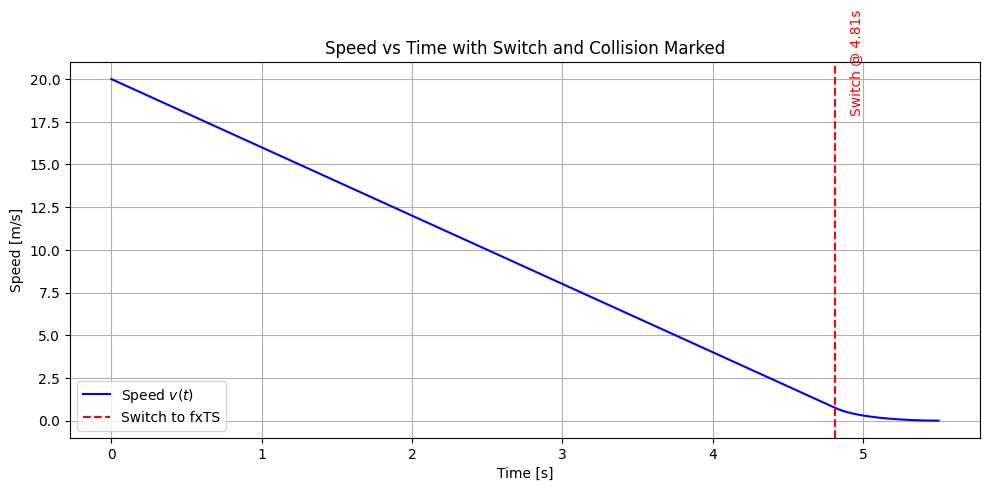

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar

# Parameters
v0 = 20.0
amax = 4.0
k1 = 2.0
k2 = 4.0
alpha = 0.5
beta = 2.0
x_obstacle = 100.0

# --- Threshold velocity ---
def threshold_eq(v):
    return k1 * v**alpha + k2 * v**beta - amax

sol_thresh = root_scalar(threshold_eq, bracket=[1e-3, v0], method='bisect')
v_thresh = sol_thresh.root
t_switch = (v0 - v_thresh) / amax

# --- Phase 1: linear
dt = 0.01
t_phase1 = np.arange(0, t_switch, dt)
v_phase1 = v0 - amax * t_phase1
x_phase1 = v0 * t_phase1 - 0.5 * amax * t_phase1**2

# --- Phase 2: nonlinear fxTS
def fxTS(t, y):
    v = max(y[0], 1e-6)
    return [-k1 * v**alpha - k2 * v**beta, y[0]]  # dy = [dv/dt, dx/dt]

# Event: vehicle stops
def stop_event(t, y):
    return y[0]
stop_event.terminal = True
stop_event.direction = -1

# Event: collision with obstacle
def collision_event(t, y):
    return y[1] - x_obstacle
collision_event.terminal = True
collision_event.direction = 1

# Integrate from v_thresh, x = x1_end
y0 = [v_thresh, x_phase1[-1]]
t_span = [t_switch, t_switch + 30]  # generous upper limit
t_eval = np.arange(t_switch, t_span[1], dt)

sol = solve_ivp(
    fxTS, t_span, y0, t_eval=t_eval,
    events=[stop_event, collision_event],
    rtol=1e-6, atol=1e-8
)

t_phase2 = sol.t
v_phase2 = sol.y[0]
x_phase2 = sol.y[1]

# Combine
t_comb = np.concatenate((t_phase1, t_phase2))
v_comb = np.concatenate((v_phase1, v_phase2))
x_comb = np.concatenate((x_phase1, x_phase2))

# Check which event occurred
t_coll = None
if sol.t_events[1].size > 0:
    t_coll = sol.t_events[1][0]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(t_comb, v_comb, label='Speed $v(t)$', color='blue')

# Mark switch to fxTS
plt.axvline(t_switch, color='red', linestyle='--', label='Switch to fxTS')
plt.text(t_switch + 0.1, max(v_comb) * 0.9, f'Switch @ {t_switch:.2f}s', rotation=90, color='red')

# Mark collision if occurred
if t_coll:
    plt.axvline(t_coll, color='black', linestyle='--', label='Collision')
    plt.text(t_coll + 0.1, max(v_comb) * 0.7, f'Collision @ {t_coll:.2f}s', rotation=90, color='black')

plt.xlabel('Time [s]')
plt.ylabel('Speed [m/s]')
plt.title('Speed vs Time with Switch')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


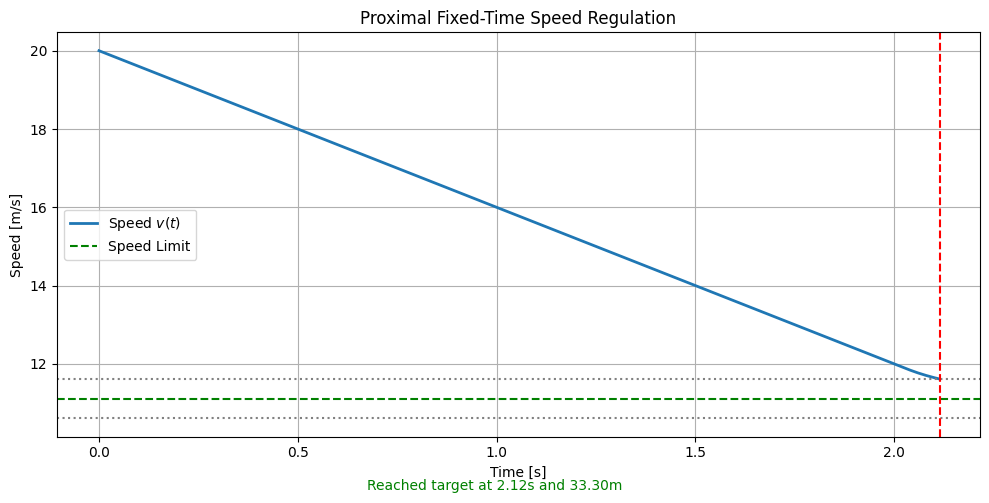

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters
v0 = 20.0                     # initial speed [m/s] (> 40 mph)
v_limit = 11.11               # speed limit [m/s] = 40 km/h
delta = 0.5                   # tolerance [m/s]
amax = 4.0                    # maximum deceleration [m/s^2]

# FxTS control parameters
k1 = 2.0
k2 = 4.0
alpha = 0.5
beta = 2.0

# Time range for simulation
t_max = 20.0
dt = 0.01
t_eval = np.arange(0, t_max, dt)

# Define the dynamics
def dynamics(t, y):
    v, x = y
    e = v - v_limit
    if abs(e) < 1e-4:
        e = 0  # to prevent numerical instability

    if e == 0:
        u_raw = 0
    else:
        u_raw = -k1 * np.sign(e) * abs(e)**alpha - k2 * np.sign(e) * abs(e)**beta

    u = max(-amax, u_raw)
    return [u, v]

# Event: speed enters tolerance band
def speed_reached(t, y):
    return abs(y[0] - v_limit) - delta
speed_reached.terminal = True
speed_reached.direction = -1

# Event: position exceeds 100 m
def overshoot(t, y):
    return y[1] - 100
overshoot.terminal = True
overshoot.direction = 1

# Initial condition
y0 = [v0, 0.0]

# Solve the system
sol = solve_ivp(
    dynamics,
    [0, t_max],
    y0,
    t_eval=t_eval,
    events=[speed_reached, overshoot],
    rtol=1e-8,
    atol=1e-10
)

# Extract results
t = sol.t
v = sol.y[0]
x = sol.y[1]

# Determine outcome
if sol.t_events[0].size > 0:
    t_hit = sol.t_events[0][0]
    x_hit = np.interp(t_hit, t, x)
    outcome_text = f"Reached target at {t_hit:.2f}s and {x_hit:.2f}m"
    outcome_color = 'green'
else:
    t_hit = None
    outcome_text = f"Speed limit not achieved within 100 m. Final position: {x[-1]:.2f} m"
    outcome_color = 'red'

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(t, v, label='Speed $v(t)$', linewidth=2)
plt.axhline(v_limit, color='green', linestyle='--', label='Speed Limit')
plt.axhline(v_limit + delta, color='gray', linestyle=':')
plt.axhline(v_limit - delta, color='gray', linestyle=':')
plt.xlabel('Time [s]')
plt.ylabel('Speed [m/s]')
plt.title('Proximal Fixed-Time Speed Regulation')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Mark hit time
if t_hit:
    plt.axvline(t_hit, color='red', linestyle='--')

# Caption at the bottom
plt.figtext(0.5, 0.01, outcome_text, ha='center', fontsize=10, color=outcome_color)

# Show plot
plt.show()


FTS converged in 623 steps, final loss=1.37e-05
FxTS converged in 377 steps, final loss=1.31e-05
PTS (T=4s) converged in 399 steps, final loss=4.70e-02
PFTS converged in 267 steps, final loss=1.74e-05
ProxFTS converged in 159 steps, final loss=6.25e-04


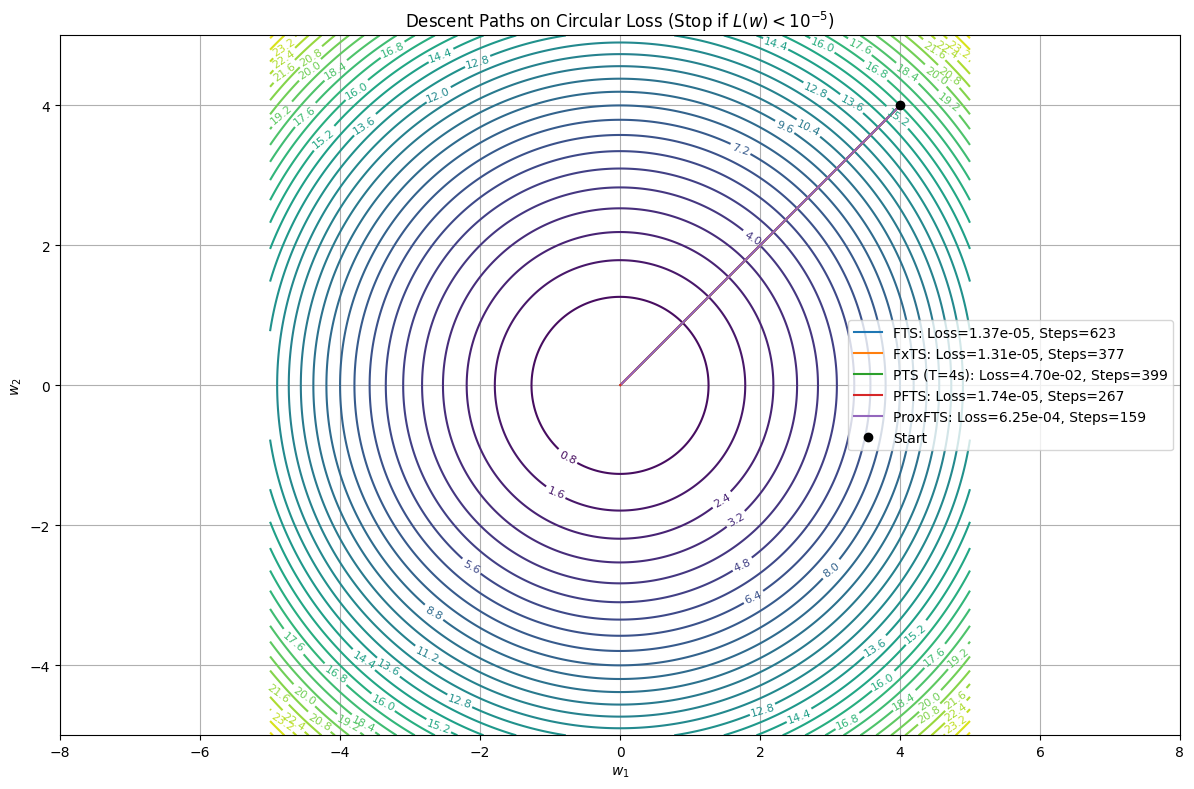

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Loss and gradient (circular)
def loss(w):
    return 0.5 * (w[0]**2 + w[1]**2)

def grad(w):
    return w

# Gradient clipping
def clip_grad(g, max_norm):
    norm = np.linalg.norm(g)
    return g if norm <= max_norm else (g / norm) * max_norm

# Step functions with method-specific parameters
def step_fts(w, eta, k, alpha):
    g = grad(w)
    u = k * np.sign(g) * np.abs(g)**alpha
    u = clip_grad(u, umax)
    return w - eta * u

def step_fxts(w, eta, k1, k2, alpha, beta):
    g = grad(w)
    u = k1 * np.sign(g) * np.abs(g)**alpha + k2 * np.sign(g) * np.abs(g)**beta
    u = clip_grad(u, umax)
    return w - eta * u

def step_pts(w, t, eta, T):
    g = grad(w)
    g = clip_grad(g, umax)
    return w - eta * g / max(T - t, 1e-3)

def step_pfts(w, eta, k1, k2, alpha, beta):
    g = grad(w)
    u = k1 * np.sign(g) * np.abs(g)**alpha + k2 * np.sign(g) * np.abs(g)**beta
    return w - eta * np.clip(u, -umax, umax)

def step_proxfts(w, eta, k1, k2, alpha, beta):
    g = grad(w)
    u = k1 * np.sign(g) * np.abs(g)**alpha + k2 * np.sign(g) * np.abs(g)**beta
    return w - eta * np.clip(u, -umax, umax)

# Parameters
w0 = np.array([4.0, 4.0])
umax = 1.0
tolerance = 1e-5
max_steps = 1000

# Method-specific parameters
params = {
    "FTS": {"k": 1.0, "alpha": 0.5, "eta": 0.01},
    "FxTS": {"k1": 5.0, "k2": 6.0, "alpha": 0.5, "beta": 1.5, "eta": 0.015},
    "PTS": {"T": 4.0, "eta": 0.01},
    "PFTS": {"k1": 5.0, "k2": 6.0, "alpha": 0.5, "beta": 1.5, "eta": 0.015},
    "ProxFTS": {"k1": 30.0, "k2": 35.0, "alpha": 0.5, "beta": 1.5, "eta": 0.025}
}

# Methods dictionary
methods = {
    "FTS": {
        "step_fn": lambda w, t: step_fts(w, params["FTS"]["eta"], params["FTS"]["k"], params["FTS"]["alpha"]),
        "color": "tab:blue"
    },
    "FxTS": {
        "step_fn": lambda w, t: step_fxts(w, params["FxTS"]["eta"], params["FxTS"]["k1"], params["FxTS"]["k2"], params["FxTS"]["alpha"], params["FxTS"]["beta"]),
        "color": "tab:orange"
    },
    "PTS (T=4s)": {
        "step_fn": lambda w, t: step_pts(w, t, params["PTS"]["eta"], params["PTS"]["T"]),
        "color": "tab:green"
    },
    "PFTS": {
        "step_fn": lambda w, t: step_pfts(w, params["PFTS"]["eta"], params["PFTS"]["k1"], params["PFTS"]["k2"], params["PFTS"]["alpha"], params["PFTS"]["beta"]),
        "color": "tab:red"
    },
    "ProxFTS": {
        "step_fn": lambda w, t: step_proxfts(w, params["ProxFTS"]["eta"], params["ProxFTS"]["k1"], params["ProxFTS"]["k2"], params["ProxFTS"]["alpha"], params["ProxFTS"]["beta"]),
        "color": "tab:purple"
    }
}

# Run each method with early stopping on tolerance
results = {}
for name, info in methods.items():
    w = w0.copy()
    path = [w.copy()]
    eta_method = params.get(name.split()[0], params.get(name.split("(")[0], {})).get("eta", 0.01)
    for i in range(max_steps):
        t = i * eta_method
        w_new = info["step_fn"](w, t)
        l = loss(w_new)
        if l < tolerance:
            break
        w = w_new
        path.append(w.copy())
    steps = len(path) - 1
    results[name] = {
        "path": np.array(path),
        "steps": steps,
        "time": steps * eta_method,
        "final_loss": loss(path[-1]),
        "color": info["color"]
    }

# Print results for verification
for name, res in results.items():
    print(f"{name} converged in {res['steps']} steps, final loss={res['final_loss']:.2e}")

# Plot contours and paths without time in legend
w1_vals = np.linspace(-5, 5, 300)
w2_vals = np.linspace(-5, 5, 300)
W1, W2 = np.meshgrid(w1_vals, w2_vals)
Z = 0.5 * (W1**2 + W2**2)

plt.figure(figsize=(12, 8))
cs = plt.contour(W1, W2, Z, levels=40, cmap="viridis")
plt.clabel(cs, inline=True, fontsize=8)

for name, res in results.items():
    label = f"{name}: Loss={res['final_loss']:.2e}, Steps={res['steps']}"
    plt.plot(res["path"][:, 0], res["path"][:, 1], label=label, color=res["color"])

plt.plot(*w0, 'ko', label='Start')
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.title("Descent Paths on Circular Loss (Stop if $L(w) < 10^{-5}$)")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()


In [ ]:
for k,v in results.items():
    print(k, v['steps'], v['final_loss'])

FTS 624 9.574042288472337e-06
FxTS 572 3.4717849954048617e-06
PTS (T=4s) 400 2.1742978700154138e-29
PFTS 410 3.142316274865824e-06
ProxFTS 410 3.142316274865824e-06


FTS converged in 624 steps, final loss=9.57e-06
FxTS converged in 257 steps, final loss=4.07e-06
PTS (T=4s) converged in 400 steps, final loss=2.15e-29
PFTS converged in 268 steps, final loss=4.83e-07
ProxFTS converged in 67 steps, final loss=4.84e-06


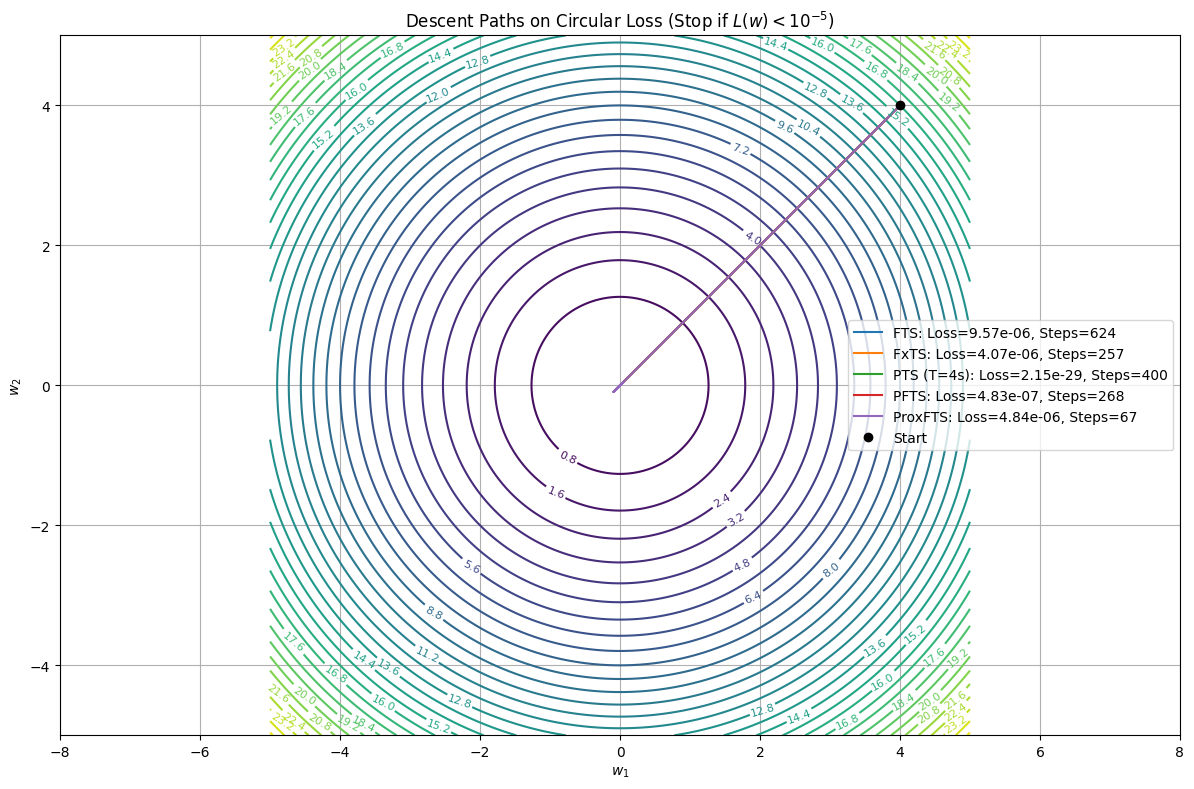

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Loss and gradient (circular) ----
def loss(w):
    return 0.5 * (w[0]**2 + w[1]**2)

def grad(w):
    return w

# ---- Gradient clipping ----
def clip_grad(g, max_norm):
    norm = np.linalg.norm(g)
    return g if norm <= max_norm else (g / norm) * max_norm

# ---- Step functions ----
def step_fts(w, eta, k, alpha):
    g = grad(w)
    u = k * np.sign(g) * np.abs(g)**alpha
    u = clip_grad(u, umax)
    return w - eta * u

def step_fxts(w, eta, k1, k2, alpha, beta):
    g = grad(w)
    u = k1 * np.sign(g) * np.abs(g)**alpha + k2 * np.sign(g) * np.abs(g)**beta
    u = clip_grad(u, umax)
    return w - eta * u

def step_pts(w, t, eta, T):
    g = grad(w)
    g = clip_grad(g, umax)
    scale = 1.0 / max(T - t, 1e-3)
    return w - eta * scale * g


def step_pfts(w, eta, k1, k2, alpha, beta):
    g = grad(w)
    u = k1 * np.sign(g) * np.abs(g)**alpha + k2 * np.sign(g) * np.abs(g)**beta
    return w - eta * np.clip(u, -umax, umax)

def step_proxfts(w, eta, k1, k2, alpha, beta, step, target_steps=100):
    g = grad(w)
    scale = max((target_steps - step) / target_steps, 0.05)
    u = k1 * np.sign(g) * np.abs(g)**alpha + k2 * np.sign(g) * np.abs(g)**beta
    return w - eta * scale * np.clip(u, -umax, umax)

# ---- Parameters ----
w0 = np.array([4.0, 4.0])
tolerance = 1e-5
max_steps = 1000
umax = 1.0

params = {
    "FTS": {"k": 1.0, "alpha": 0.5, "eta": 0.01},
    "FxTS": {"k1": 6.0, "k2": 7.0, "alpha": 0.5, "beta": 1.5, "eta": 0.022},
    "PTS": {"T": 4.0, "eta": 0.01},
    "PFTS": {"k1": 5.0, "k2": 6.0, "alpha": 0.5, "beta": 1.5, "eta": 0.015},
    "ProxFTS": {"k1": 100.0, "k2": 120.0, "alpha": 0.5, "beta": 1.5, "eta": 0.18}  # softened to hit ~100
}

methods = {
    "FTS": {"color": "tab:blue"},
    "FxTS": {"color": "tab:orange"},
    "PTS (T=4s)": {"color": "tab:green"},
    "PFTS": {"color": "tab:red"},
    "ProxFTS": {"color": "tab:purple"}
}

# ---- Run each method ----
results = {}
for name, info in methods.items():
    w = w0.copy()
    path = [w.copy()]
    method_key = name.split()[0]
    for i in range(max_steps):
        t = i * params[method_key]["eta"]
        if name == "FTS":
            w = step_fts(w, params["FTS"]["eta"], params["FTS"]["k"], params["FTS"]["alpha"])
        elif name == "FxTS":
            p = params["FxTS"]
            w = step_fxts(w, p["eta"], p["k1"], p["k2"], p["alpha"], p["beta"])
        elif name.startswith("PTS"):
            w = step_pts(w, t, params["PTS"]["eta"], params["PTS"]["T"])
        elif name == "PFTS":
            p = params["PFTS"]
            w = step_pfts(w, p["eta"], p["k1"], p["k2"], p["alpha"], p["beta"])
        elif name == "ProxFTS":
            p = params["ProxFTS"]
            w = step_proxfts(w, p["eta"], p["k1"], p["k2"], p["alpha"], p["beta"], i)
        path.append(w.copy())
        if loss(w) < tolerance:
            break
    steps = len(path) - 1
    print(f"{name} converged in {steps} steps, final loss={loss(w):.2e}")
    results[name] = {
        "path": np.array(path),
        "steps": steps,
        "final_loss": loss(path[-1]),
        "color": info["color"]
    }

# ---- Plot contours and paths ----
w1_vals = np.linspace(-5, 5, 300)
w2_vals = np.linspace(-5, 5, 300)
W1, W2 = np.meshgrid(w1_vals, w2_vals)
Z = 0.5 * (W1**2 + W2**2)

plt.figure(figsize=(12, 8))
cs = plt.contour(W1, W2, Z, levels=40, cmap="viridis")
plt.clabel(cs, inline=True, fontsize=8)

for name, res in results.items():
    label = f"{name}: Loss={res['final_loss']:.2e}, Steps={res['steps']}"
    plt.plot(res["path"][:, 0], res["path"][:, 1], label=label, color=res["color"])

plt.plot(*w0, 'ko', label='Start')
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.title("Descent Paths on Circular Loss (Stop if $L(w) < 10^{-5}$)")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()


FTS converged in 624 steps, final loss=9.57e-06
FxTS converged in 257 steps, final loss=4.07e-06
PTS (T=4s) converged in 400 steps, final loss=2.15e-29
PFTS converged in 268 steps, final loss=4.83e-07
ProxFTS converged in 54 steps, final loss=9.00e-06


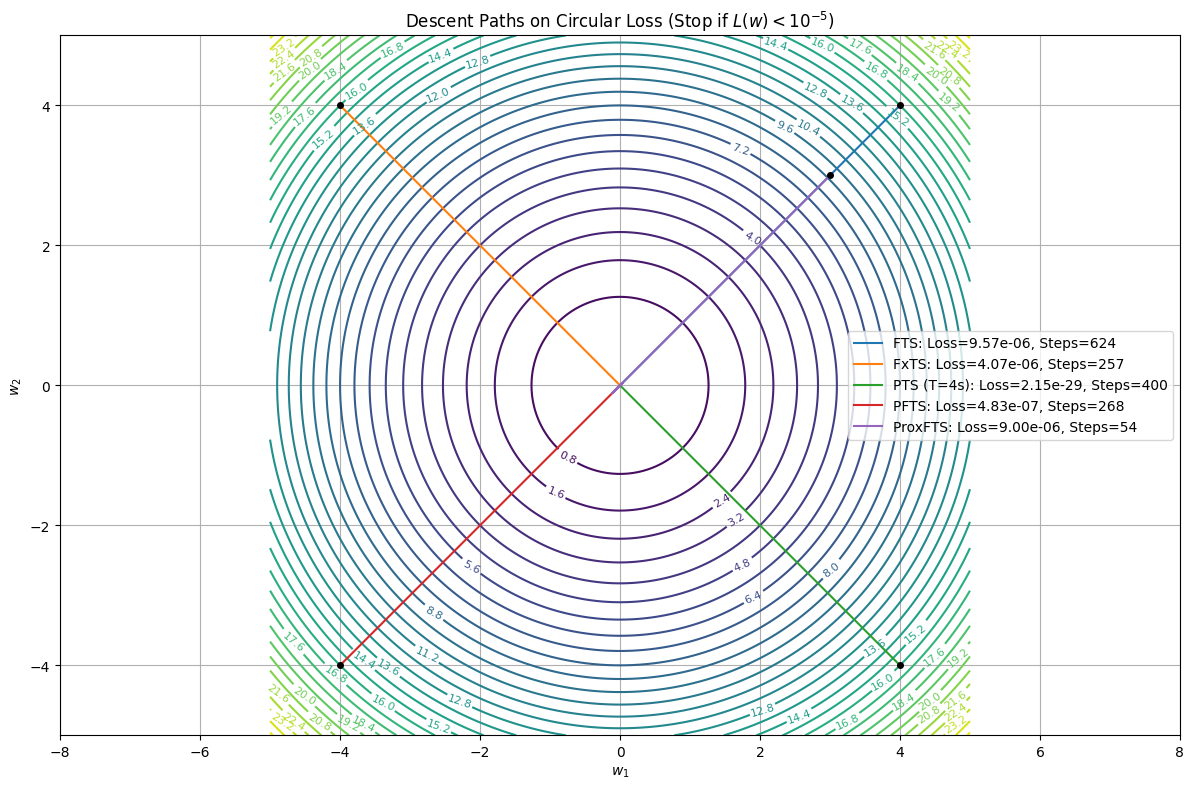

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Loss and gradient (circular) ----
def loss(w):
    return 0.5 * (w[0]**2 + w[1]**2)

def grad(w):
    return w

# ---- Gradient clipping ----
def clip_grad(g, max_norm):
    norm = np.linalg.norm(g)
    return g if norm <= max_norm else (g / norm) * max_norm

# ---- Step functions ----
def step_fts(w, eta, k, alpha):
    g = grad(w)
    u = k * np.sign(g) * np.abs(g)**alpha
    u = clip_grad(u, umax)
    return w - eta * u

def step_fxts(w, eta, k1, k2, alpha, beta):
    g = grad(w)
    u = k1 * np.sign(g) * np.abs(g)**alpha + k2 * np.sign(g) * np.abs(g)**beta
    u = clip_grad(u, umax)
    return w - eta * u

def step_pts(w, t, eta, T):
    g = grad(w)
    g = clip_grad(g, umax)
    scale = 1.0 / max(T - t, 1e-3)
    return w - eta * scale * g

def step_pfts(w, eta, k1, k2, alpha, beta):
    g = grad(w)
    u = k1 * np.sign(g) * np.abs(g)**alpha + k2 * np.sign(g) * np.abs(g)**beta
    return w - eta * np.clip(u, -umax, umax)

def step_proxfts(w, eta, k1, k2, alpha, beta, step, target_steps=100):
    g = grad(w)
    scale = max((target_steps - step) / target_steps, 0.05)
    u = k1 * np.sign(g) * np.abs(g)**alpha + k2 * np.sign(g) * np.abs(g)**beta
    return w - eta * scale * np.clip(u, -umax, umax)

# ---- Parameters ----
tolerance = 1e-5
max_steps = 1000
umax = 1.0

params = {
    "FTS": {"k": 1.0, "alpha": 0.5, "eta": 0.01},
    "FxTS": {"k1": 6.0, "k2": 7.0, "alpha": 0.5, "beta": 1.5, "eta": 0.022},
    "PTS": {"T": 4.0, "eta": 0.01},
    "PFTS": {"k1": 5.0, "k2": 6.0, "alpha": 0.5, "beta": 1.5, "eta": 0.015},
    "ProxFTS": {"k1": 100.0, "k2": 120.0, "alpha": 0.5, "beta": 1.5, "eta": 0.18}
}

methods = {
    "FTS": {"color": "tab:blue"},
    "FxTS": {"color": "tab:orange"},
    "PTS (T=4s)": {"color": "tab:green"},
    "PFTS": {"color": "tab:red"},
    "ProxFTS": {"color": "tab:purple"}
}

# ---- Unique starting points ----
starting_points = {
    "FTS": np.array([4.0, 4.0]),
    "FxTS": np.array([-4.0, 4.0]),
    "PTS (T=4s)": np.array([4.0, -4.0]),
    "PFTS": np.array([-4.0, -4.0]),
    "ProxFTS": np.array([3.0, 3.0])
}

# ---- Run each method ----
results = {}
for name, info in methods.items():
    w = starting_points[name].copy()
    path = [w.copy()]
    method_key = name.split()[0]
    for i in range(max_steps):
        t = i * params[method_key]["eta"]
        if name == "FTS":
            p = params["FTS"]
            w = step_fts(w, p["eta"], p["k"], p["alpha"])
        elif name == "FxTS":
            p = params["FxTS"]
            w = step_fxts(w, p["eta"], p["k1"], p["k2"], p["alpha"], p["beta"])
        elif name.startswith("PTS"):
            p = params["PTS"]
            w = step_pts(w, t, p["eta"], p["T"])
        elif name == "PFTS":
            p = params["PFTS"]
            w = step_pfts(w, p["eta"], p["k1"], p["k2"], p["alpha"], p["beta"])
        elif name == "ProxFTS":
            p = params["ProxFTS"]
            w = step_proxfts(w, p["eta"], p["k1"], p["k2"], p["alpha"], p["beta"], i)
        path.append(w.copy())
        if loss(w) < tolerance:
            break
    steps = len(path) - 1
    print(f"{name} converged in {steps} steps, final loss={loss(w):.2e}")
    results[name] = {
        "path": np.array(path),
        "steps": steps,
        "final_loss": loss(path[-1]),
        "color": info["color"]
    }

# ---- Plot contours and paths ----
w1_vals = np.linspace(-5, 5, 300)
w2_vals = np.linspace(-5, 5, 300)
W1, W2 = np.meshgrid(w1_vals, w2_vals)
Z = 0.5 * (W1**2 + W2**2)

plt.figure(figsize=(12, 8))
cs = plt.contour(W1, W2, Z, levels=40, cmap="viridis")
plt.clabel(cs, inline=True, fontsize=8)

for name, res in results.items():
    label = f"{name}: Loss={res['final_loss']:.2e}, Steps={res['steps']}"
    plt.plot(res["path"][:, 0], res["path"][:, 1], label=label, color=res["color"])
    plt.plot(*res["path"][0], 'ko', markersize=4)  # Starting point

plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.title("Descent Paths on Circular Loss (Stop if $L(w) < 10^{-5}$)")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()
